In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0, '../')
from scipy.optimize import minimize
from scipy.stats import beta
import util.util as util
from util.util import evaluate,SAA_minimise
from scipy.stats import wasserstein_distance

In [11]:
# beta distribution
Y = beta(a = 3,b=3,loc=-1,scale=2)
Sy = Y.rvs(50)
sort_Sy = np.sort(Sy)

In [3]:
def wasserstein_constraint(limit,samples,delta):
    distance =np.mean(np.concatenate((limit[0] - samples[limit[0] > samples],
               samples[limit[1] < samples] - limit[1])))
    return  delta-distance

In [4]:
def limit_constraint(limit):
    return limit[1]-limit[0]

In [5]:
def plot_sample_change(x_star,Sy,new_y,func):
    
    # get a plot of the cost function
    temp_y = np.linspace(np.min(Sy),np.max(Sy),500)
    full_cost = evaluate(x_star,temp_y,func,find_mean=False)
    
    # get cost of samples
    sub_cost = evaluate(x_star,Sy,func,find_mean=False)
    # cost of changed samples
    altered = evaluate(x_star,new_y,func,find_mean=False)
    
    # check which samples have changed
    changed_index = np.isclose(Sy,new_y,atol=1e-2) == False
    
    changed_samples = new_y[changed_index]
    changed_cost = evaluate(x_star,changed_samples,func,find_mean=False)
    original_samples = Sy[changed_index]
    original_cost = sub_cost[changed_index]
    
    # plot the hraph
    plt.figure(figsize=(10,8))
    plt.plot(temp_y,full_cost,label='cost function')
    plt.plot(Sy,sub_cost,'o',label='samples')

    plt.plot(changed_samples,original_cost,'o',label='altered samples')
    for i in range(len(changed_cost)):
        plt.arrow(original_samples[i],
                  original_cost[i],
                  (changed_samples[i]-original_samples[i])*0.7,
                  0,head_width=0.02,length_includes_head=False)
    plt.legend()

In [21]:
def test(limit,x_star,samples,func):
    #new_Sy = np.copy(samples)
    #new_Sy[:np.searchsorted(sort_Sy,limit[0],'right')] = limit[0]
    #new_Sy[np.searchsorted(sort_Sy,limit[1],'left'):] = limit[1]
    
    new_Sy = alter_samples(limit,samples)
    return -evaluate(x_star,new_Sy,func)

In [22]:
def alter_samples(limit,samples):
    samples[:np.searchsorted(samples,limit[0],'right')] = limit[0]
    samples[np.searchsorted(samples,limit[1],'left'):] = limit[1]
    
    return samples

In [23]:
def wasserstein_robustification(samples,x_star,func,constraint,bound):
    limit = [samples[1],samples[-2]]
    res = minimize(test,limit,args=(x_star,samples,func),
                   constraints=constraint,bounds=bound,
                  options={'maxiter': 500,
                          'ftol': 1e-06})
    new_samples = alter_samples(res.x,samples)
    return samples

In [24]:
delta = 0.4
x_star = SAA_minimise(Sy,util.f1)

In [25]:
constraint = [{'type':'ineq','fun':wasserstein_constraint,'args':[Sy,delta]},
             {'type':'ineq','fun':limit_constraint}]
bound = [(-1,1)]*2
new_sample = wasserstein_robustification(sort_Sy,x_star,util.f1,constraint,bound)

In [28]:
wasserstein_distance(sort_Sy,new_sample)

0.28910762896594183

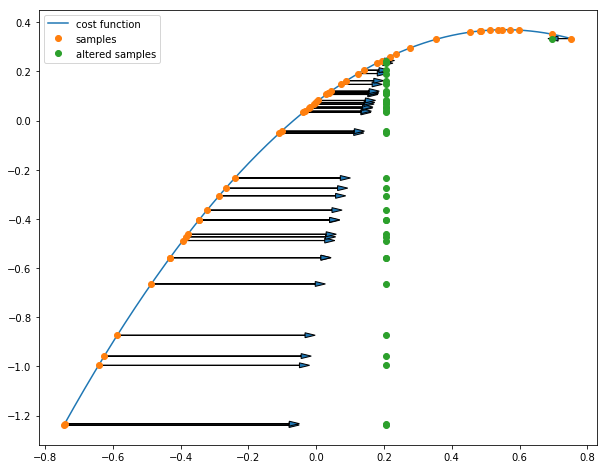

In [29]:
plot_sample_change(x_star,sort_Sy,new_sample,util.f1)